## Import libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import joblib as jl
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
import scikitplot as skplt

import warnings
warnings.simplefilter('ignore')

## Import Dataset

In [58]:
dataset = pd.read_csv('Data/dogs_intakes_outcomes_clean.csv')



# Check for null values in important features

In [59]:
# dataset.apply(lambda x: sum(x.isnull()/len(dataset)))

## Setting dependent variable categories

In [60]:
dataset =  dataset.loc[(dataset['outcome_type'] == 'Adoption')                                  
                                 | (dataset['outcome_type'] == 'Transfer')
                                 | (dataset['outcome_type'] == 'Return to Owner')
                                 | (dataset['outcome_type'] == 'Euthanasia')]

#dataset['outcome_subtype'] = np.where(pd.isnull(dataset['outcome_subtype']), 
#                                           dataset['outcome_type'], 
#                                           dataset['outcome_subtype'])

In [61]:
x = dataset.filter(items=['sex', 'spay/neuter', 'mixed_breed', 'time_in_shelter_days_12',
                         'coat', 'intake_hour', 'intake_weekday', 'intake_month', 'intake_year', 'age_upon_intake_age_group',
                         'intake_condition_clean', 'intake_type', 'Puppy/Dog_intake', 'Bully_breed'])

# ['sex', 'spay/neuter', 'mixed_breed', 'breed', 'time_in_shelter_days_6', 'coat'
#                         , 'intake_hour', 'intake_weekday', 'intake_month', 'age_upon_intake_age_group',
#                         'intake_condition', 'intake_type', 'Puppy/Dog_intake']


In [62]:
for col in x:
    x[col] = x[col].astype('category')
print(x.dtypes)
y = dataset['outcome_type'].astype('category')



sex                          category
spay/neuter                  category
mixed_breed                  category
time_in_shelter_days_12      category
coat                         category
intake_hour                  category
intake_weekday               category
intake_month                 category
intake_year                  category
age_upon_intake_age_group    category
intake_condition_clean       category
intake_type                  category
Puppy/Dog_intake             category
Bully_breed                  category
dtype: object


In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# xd = pd.get_dummies(x)
# xnames = xd.columns
# xarr = np.array(xd)
# print(xarr[0])

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [*range(0, 14, 1)])], remainder='passthrough')
xarr = np.array(ct.fit_transform(x))
print(xarr[0])

[0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


In [82]:
yarr, ynames = pd.factorize(dataset['outcome_type'])

# Split x and y arrays into training and testing sets

In [83]:


x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

In [84]:
# scaler = preprocessing.StandardScaler()

# x_train_scaled = scaler.fit_transform(x_train)
# x_test_scaled = scaler.transform(x_test)

# Use PCA to reduce dimensions

In [85]:


pca = PCA()
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

111


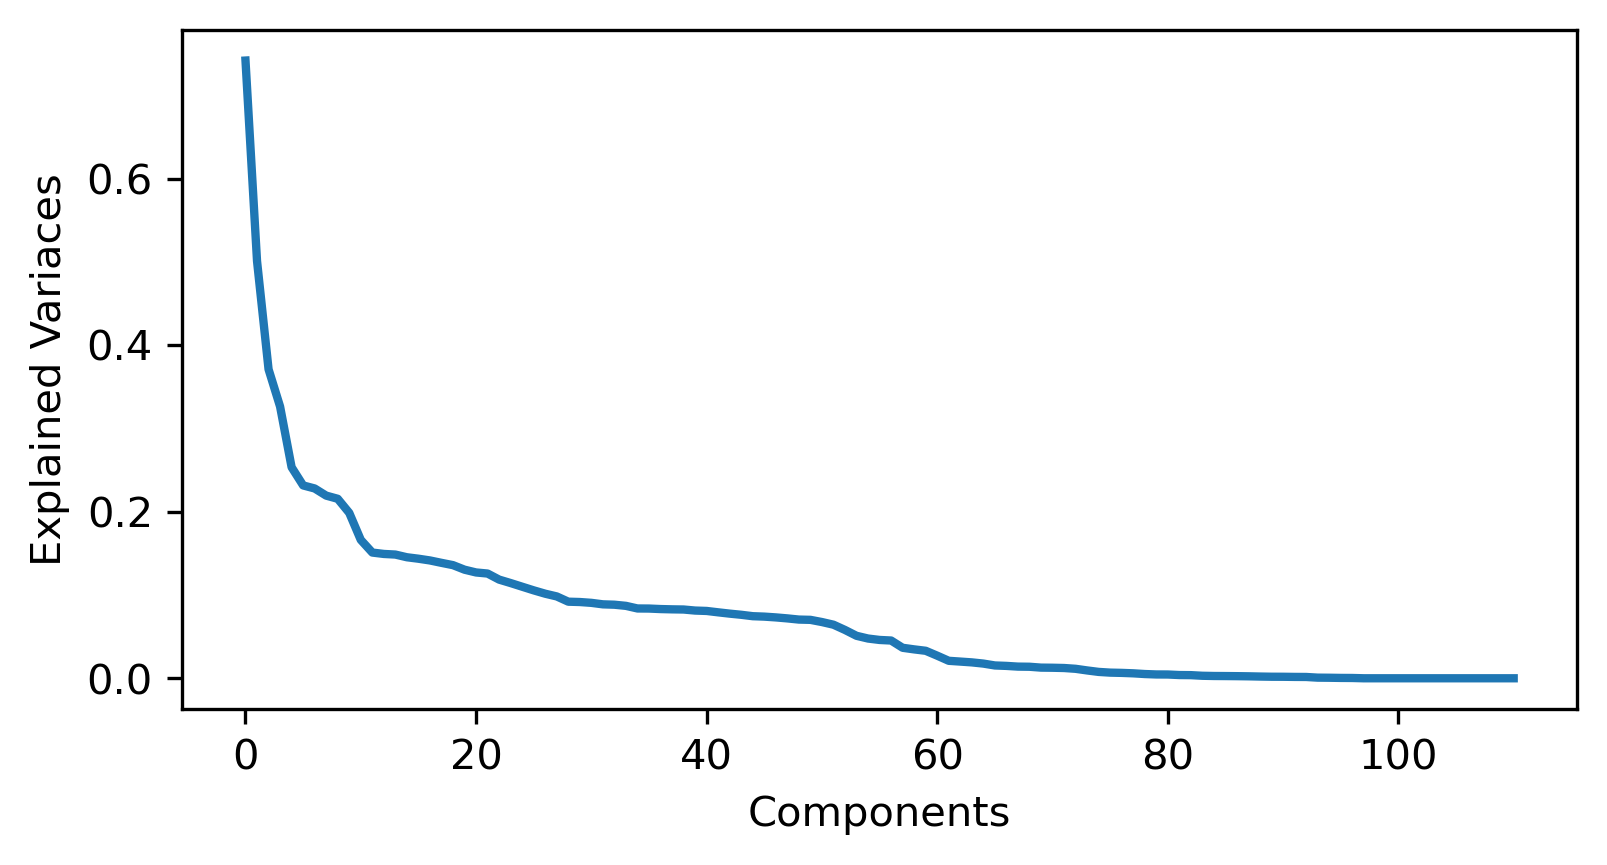

In [86]:
from matplotlib.pyplot import figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import show

print(len(pca.components_))
figure(1, figsize=(6,3), dpi=300)
plot(pca.explained_variance_, linewidth=2)
xlabel('Components')
ylabel('Explained Variaces')
show()

# Chain kbest feature extration to PCA with feature union

In [87]:


feature_union = FeatureUnion([
    ('pca', PCA(n_components = 90)),
    ('kbest', SelectKBest(k=2))
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=500, criterion='entropy', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])




prediction_model.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=90,
                                                     random_state=None,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('kbest',
                                                 SelectKBest(k=2,
                                                             score_func=<function f_classif at 0x000002870FC88D38>))],
                              transformer_weights=None, verbose=False)),
                ('rf',
                 RandomForestClassifier(bootstrap=True,
                  

##### import warnings
warnings.simplefilter('ignore')

prediction_model.fit(x_train_scaled, y_train)

# Test prediction with StratifiedKFold

In [88]:
from sklearn.metrics import accuracy_score, classification_report

import warnings

warnings.simplefilter('ignore')

cv = StratifiedKFold(4)
cv_score = cross_val_score(prediction_model, x_train, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train, y_train, cv=cv)



In [106]:
test_single = x.iloc[12]

test_single = ct.transform([test_single])
print(test_single)

print(prediction_model.predict(test_single))

[[0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]]
[2]


In [90]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

[0.75 0.74 0.74 0.76]
0.7482283327617867
0.7484824408072461


In [91]:
rf_pred = prediction_model.predict(x_test)

In [92]:
print(accuracy_score(y_test, rf_pred))

0.7531514162835533


[0]
[0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]


Confusion matrix, without normalization
[[3342   51  543   31]
 [ 328  607 1895   29]
 [ 199  128 5873    9]
 [  37   53   26  335]]
Normalized confusion matrix
[[0.84 0.01 0.14 0.01]
 [0.11 0.21 0.66 0.01]
 [0.03 0.02 0.95 0.  ]
 [0.08 0.12 0.06 0.74]]


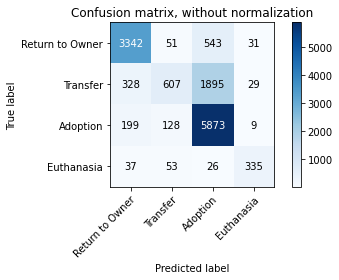

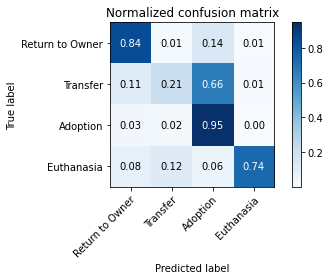

In [94]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ynames
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

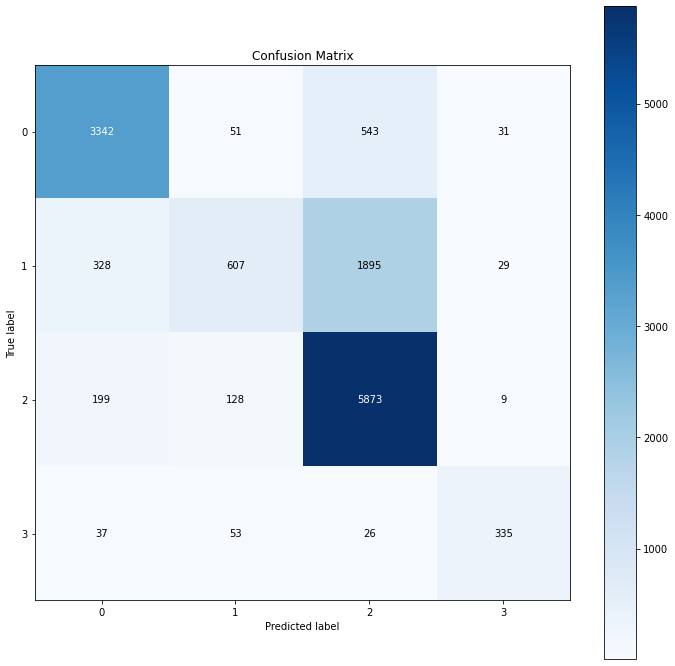

In [95]:


skplt.metrics.plot_confusion_matrix(y_test, rf_pred, figsize=(12,12))

# Parameter tuning

In [189]:
criterion = ['gini', 'entropy']
components = [80, 100, 105, 110]
estimators = [100, 300, 500, 750]
k = [0, 2, 4]



In [190]:
from sklearn.multiclass import OneVsRestClassifier

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model_tune = Pipeline([
    ('feature_union', feature_union),
    ('rf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample', 
                                                      bootstrap=True, oob_score=True)))
])

rf_gridcv = GridSearchCV(prediction_model_tune, dict(feature_union__pca__n_components=components, 
                                                     feature_union__kbest__k=k, 
                                                     rf__estimator__n_estimators=estimators, 
                                                     rf__estimator__criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

In [191]:
rf_gridcv.fit(x_train_scaled, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('feature_union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pca',
                                                                        PCA(copy=True,
                                                                            iterated_power='auto',
                                                                            n_components=None,
                                                                            random_state=None,
                                                                            svd_solver='auto',
                                                                            tol=0.0,
                                                                        

# Save model

In [192]:
jl.dump(rf_gridcv, 'Data/rfg4outcomes.pkl') 

['Data/rfg4outcomes.pkl']

# Convert grid to pandas dataframa

In [244]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=False, inplace=True)
results.tail(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_union__kbest__k,param_feature_union__pca__n_components,param_rf__estimator__criterion,param_rf__estimator__n_estimators,params,split0_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
62,557.568164,11.704647,2.964753,0.09364,2,110,entropy,500,"{'feature_union__kbest__k': 2, 'feature_union_...",0.74385,...,0.739312,0.740559,0.002164,1,0.998943,0.998985,0.998816,0.998816,0.99889,0.000075


Confusion matrix, without normalization
[[3376   33  575   17]
 [ 372  587 1941   28]
 [ 217   75 5854    8]
 [  52   41   29  311]]
Normalized confusion matrix
[[0.84 0.01 0.14 0.  ]
 [0.13 0.2  0.66 0.01]
 [0.04 0.01 0.95 0.  ]
 [0.12 0.09 0.07 0.72]]


<Figure size 864x864 with 0 Axes>

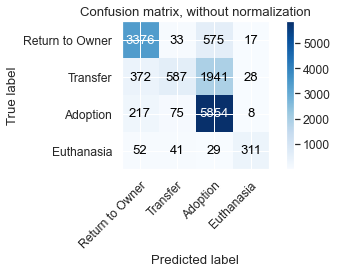

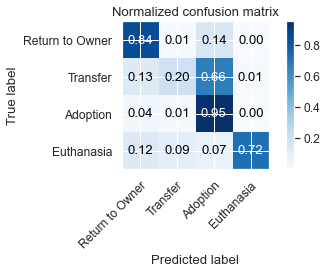

In [194]:
sns.set(font_scale=1.1)

rf_grid_pred = rf_gridcv.predict(x_test_scaled)
rf_cnf_mat = confusion_matrix(y_test, rf_grid_pred)

plt.figure(figsize=(12, 12))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, rf_grid_pred, classes=ynames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rf_grid_pred, classes=ynames, normalize=True,
                      title='Normalized confusion matrix')

In [195]:
print(accuracy_score(y_test, rf_grid_pred))

0.749334122521456


## Make single prediction

In [118]:


new_pred = [['Female', 'Yes', 'Purebred', '(-0.001, 0.21]', 'tricolor', 3, 'Wednesday', 12,
                            2017, '(2.5, 5.0]', 'Normal', 'Stray', 'Dog', 'Not Bully']]



x = dataset.filter(items=['sex', 'spay/neuter', 'mixed_breed', 'time_in_shelter_days_12',
                         'coat', 'intake_hour', 'intake_weekday', 'intake_month', 'intake_year', 'age_upon_intake_age_group',
                         'intake_condition_clean', 'intake_type', 'Puppy/Dog_intake', 'Bully_breed'])
for col in x:
    x[col] = x[col].astype('category')
    



df_single = pd.DataFrame(new_pred,columns=x.columns)
for col in df_single:
    df_single[col] = df_single[col].astype('category')
print(np.array(df_single))
pred_single = ct.transform(df_single)
print(pred_single)

df_test = df_single.append(x.iloc[-1])
# print(x)

[['Female' 'Yes' 'Purebred' '(-0.001, 0.21]' 'tricolor' 3 'Wednesday' 12
  2017 '(2.5, 5.0]' 'Normal' 'Stray' 'Dog' 'Not Bully']]
[[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]]


In [119]:
print(prediction_model.predict(pred_single))

[0]


NameError: name 'dummy_new' is not defined